<a href="https://colab.research.google.com/github/willywithcode/Vietnamese_Detection_TrainModel/blob/main/vietnamese_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
import keras

In [ ]:
if tf.test.is_gpu_available():
    print('GPU is available.')
else:
    print('GPU is NOT available.')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available.


In [ ]:
def resnet_block(inputs, filters, strides=1, drop_rate=0.2):
    # Convolution block
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    
    # Skip connection
    if strides > 1:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    
    x = keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    return x

def resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    # Global average pooling and fully-connected layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
input_shape = (128, 128, 3) 
num_classes = 2

optimizer = Adam(learning_rate=0.0003)
model = resnet_model(input_shape, num_classes)
model.compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 64, 64, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_50 (BatchN  (None, 64, 64, 64)  256         ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                            

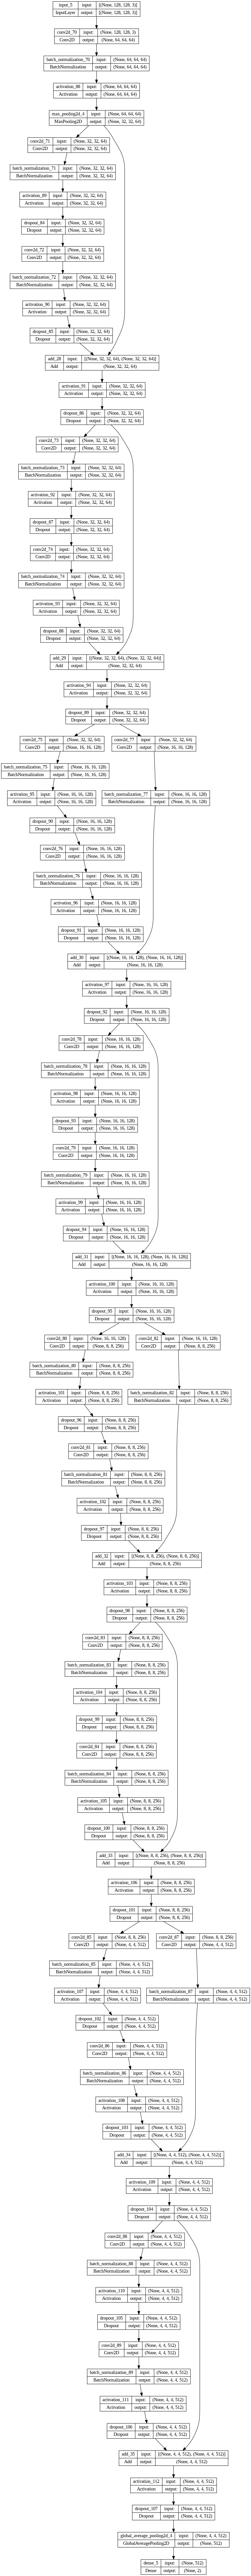

In [ ]:
from tensorflow.keras.utils import plot_model
model = resnet_model(input_shape, num_classes)

plot_model(model, to_file='resnet_model.png', show_shapes=True)

In [ ]:
import glob
name_label = []
X = []
name_list_1 = glob.glob("/content/drive/MyDrive/data/vietnam_detect/test/foreigner/*")
name_list_2 = glob.glob("/content/drive/MyDrive/data/vietnam_detect/test/vietnamese/*")
for name in name_list_1:
    name_label.append(1)
    img = cv2.imread(name)
    img = cv2.resize(img, (128, 128))
    X.append(img)
for name in name_list_2:
    name_label.append(0)
    img = cv2.imread(name)
    img = cv2.resize(img, (128, 128))
    X.append(img)

len(X)

2000

In [ ]:
name_list_1 = glob.glob("/content/drive/MyDrive/data/vietnam_detect/train/foreigner/*")
name_list_2 = glob.glob("/content/drive/MyDrive/data/vietnam_detect/train/vietnamese/*")
for name in name_list_1:
    name_label.append(1)
    img = cv2.imread(name)
    img = cv2.resize(img, (128, 128))
    X.append(img)
for name in name_list_2:
    name_label.append(0)
    img = cv2.imread(name)
    img = cv2.resize(img, (128, 128))
    X.append(img)
len(X)

13000

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

X = np.array(X, dtype="float32") / 255.0
y = np.array(name_label, dtype="int32")
y_one_hot = to_categorical(y) # 0 -> [1, 0] ; 1 -> [0, 1]
print(X.shape)
print(y.shape)

(13000, 128, 128, 3)
(13000,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, 
                                                    test_size=0.008, 
                                                    random_state=42,
                                                    shuffle=True)

In [ ]:
with tf.device('GPU'):
    model.fit(X_train, y_train, epochs=100, batch_size=8)

Epoch 1/100
1612/1612 [==============================] - 56s 24ms/step - loss: 0.2644 - accuracy: 0.8934
Epoch 2/100
1612/1612 [==============================] - 39s 24ms/step - loss: 0.1118 - accuracy: 0.9626
Epoch 3/100
1612/1612 [==============================] - 39s 24ms/step - loss: 0.0839 - accuracy: 0.9708
Epoch 4/100
1612/1612 [==============================] - 39s 24ms/step - loss: 0.0782 - accuracy: 0.9743
Epoch 5/100
1612/1612 [==============================] - 39s 24ms/step - loss: 0.0670 - accuracy: 0.9783
Epoch 6/100
1612/1612 [==============================] - 38s 24ms/step - loss: 0.0555 - accuracy: 0.9811
Epoch 7/100
1612/1612 [==============================] - 39s 24ms/step - loss: 0.0516 - accuracy: 0.9819
Epoch 8/100
1612/1612 [==============================] - 39s 24ms/step - loss: 0.0452 - accuracy: 0.9847
Epoch 9/100
1612/1612 [==============================] - 39s 24ms/step - loss: 0.0477 - accuracy: 0.9839
Epoch 10/100
1612/1612 [==============================]

In [ ]:
with tf.device('GPU'):
    loss, accuracy = model.evaluate(X_test, y_test)

    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

4/4 [==============================] - 1s 15ms/step - loss: 0.0035 - accuracy: 1.0000
Test Loss: 0.003499728161841631
Test Accuracy: 1.0


In [ ]:
save_dir = "/content/drive/MyDrive/Research/ResNet_detect/vietname_detection_11_model.h5"
tf.keras.models.save_model(model, save_dir)

In [ ]:
from tensorflow.keras.models import load_model
inference = load_model('/content/drive/MyDrive/Research/ResNet_detect/vietname_detection_9_model.h5')

In [ ]:
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=2c16397229f4b2a770adf4bbdd90fe3079e55a364ed48ed71bc4d8b596571d4e
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
from PIL import Image
import face_recognition
def get_face_img(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes_face = face_recognition.face_locations(img)
    face_image = None
    if len(boxes_face)!=0:
        for box_face in boxes_face:
            box_face_fc = box_face
            x0,y1,x1,y0 = box_face
            box_face = np.array([y0,x0,y1,x1])
            face_image = img[x0:x1,y0:y1]
    return face_image

In [ ]:
import cv2
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image
a = get_face_img('/content/original.jpg')
a = cv2.resize(a, (128,128))/255
a = a[None, :]

In [ ]:
inference.predict(a)

1/1 [==============================] - 0s 21ms/step


array([[2.0519461e-14, 1.0000000e+00]], dtype=float32)

In [ ]:
inference = tf.keras.models.load_model("resource/vietname_detection_model.h5")

import cv2
import os
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(0)

cv2.waitKey(1000)

while True:
    ret, frame = cap.read()
    input = cv2.resize(frame, (128, 128))/255
    input = input[None, :]
    prediction = inference.predict(input)
    if (1> prediction[0][0] >= 0.5): 
        print(f"{prediction[0][0]:.2f}")
        cv2.putText(frame, "foreigner", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0))
    elif (0< prediction[0][0] < 0.5):
        print(f"{prediction[0][0]:.2f}")
        cv2.putText(frame, "vietnam", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0))
    cv2.imshow('Camera', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()